In [1]:
import numpy as np
import keras
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# from models import *
from plot import *
from data import Dataset

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

DIR = '/home/disij/projects/cifar-10h/data/'

In [2]:
dataset = Dataset.load_from_text('cifar10')
dataset.split_train_eval(ratio=0.8)
n, k = dataset.s_model.shape


Training and apply temperature scaling to human predictor...
Before temperature - NLL: 0.069, ECE: 0.038
Optimal temperature: 0.295
After temperature - NLL: 0.060, ECE: 0.003
Training and apply temperature scaling to model predictor...
Before temperature - NLL: 0.408, ECE: 0.052
Optimal temperature: 2.080
After temperature - NLL: 0.346, ECE: 0.031


/home/disij/projects/cifar-10h/src/models.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits).cuda()
/home/disij/projects/cifar-10h/src/data.py:75: RuntimeWarning: divide by zero encountered in log
  self.calibrated_logits_human = temperature_model(np.log(self.s_human)).cpu().data.numpy()


(<Figure size 864x360 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f46cf249f90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f46cf354910>))

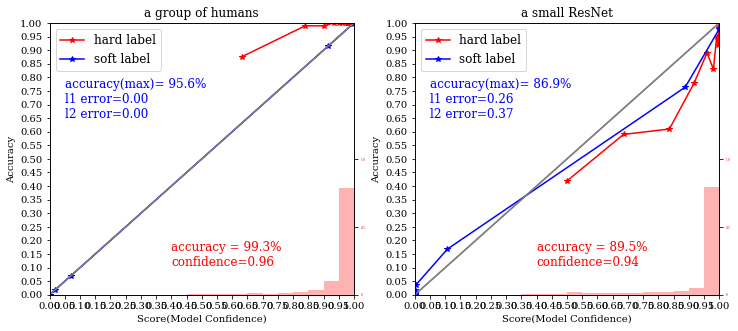

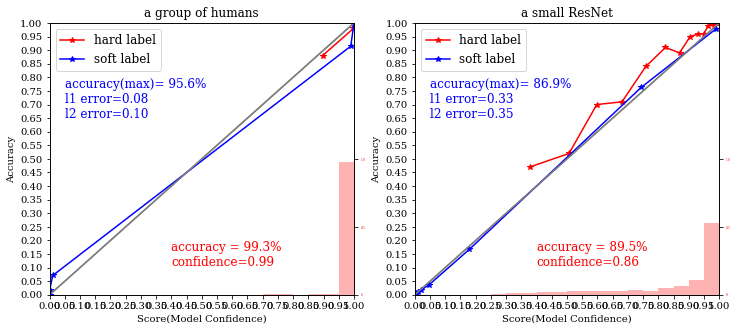

In [3]:
dataset.calibration('temperature_scaling')
dataset.plot_reliability()
dataset.plot_calibrated_reliability()


Training and apply temperature scaling to human predictor...
Optimal temperature: 0.890
Training and apply temperature scaling to model predictor...
Optimal temperature: 2.528


/home/disij/projects/cifar-10h/src/models.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits).cuda()
/home/disij/projects/cifar-10h/src/data.py:93: RuntimeWarning: divide by zero encountered in log
  self.calibrated_logits_human = temperature_model(np.log(self.s_human)).cpu().data.numpy()


(<Figure size 864x360 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f46cf3d1f50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f46cfb6f790>))

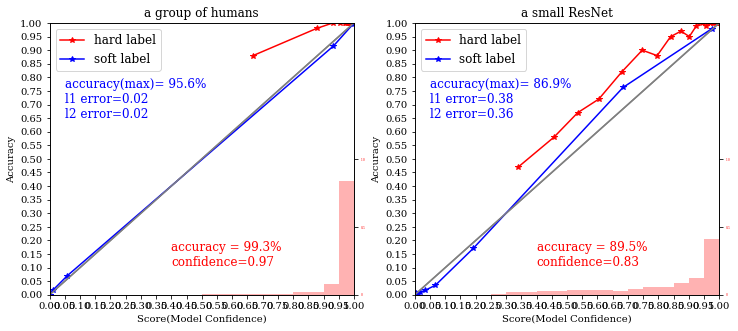

In [4]:
dataset.calibration_to_distribution('temperature_scaling')
dataset.plot_calibrated_reliability()

- to explain the figure above
    1. true calibration and accuracy is worst than current estimates? because the randomness of y|x is ignored with binary label?
    2. for the figure on the left: the binary labels itself is an overocnfident estimation of true labels  => 1
    3. should ground truth (binary labels) of examples be considered as samples from true label distributions or the consensus of a group of humans? 
- calibrate model scores to human uncertainty
- how useful is the vector of scores that a model generates?
- calibrate to human label distributions?

### accuracy estimation with more samples from p(y|x)

In [5]:
def sample_prediction_counts(y_counts): # draw one label for each sample
    sampled_y_counts = np.zeros(y_counts.shape)
    n, k = y_counts.shape
    assert np.sum(y_counts, axis=1).min() >= 1
    samples = np.array([np.random.choice(k, 1, p= y_counts[i]/y_counts[i].sum())[0] for i in range(n)])
    sampled_y_counts[np.arange(n), samples] += 1
    y_counts[np.arange(n), samples] -= 1
    
    return sampled_y_counts, y_counts

In [6]:
# sample labels points
num_runs = 5
num_labelers = 47
from copy import deepcopy
sampled_human_labels = np.zeros((num_runs, num_labelers, n, k))
for r in range(num_runs):
    pool_of_human_labels = deepcopy(dataset.human_counts)
    for i in range(num_labelers):
        sampled_human_labels[r, i], pool_of_human_labels = sample_prediction_counts(pool_of_human_labels)

# accuracy
acc = np.zeros((num_runs, num_labelers))
for r in range(num_runs):
    human_labels = np.zeros(dataset.human_counts.shape)
    for i in range(num_labelers):
        human_labels += sampled_human_labels[r, i]
        y_pred = np.argmax(human_labels, axis=1)
        acc[r,i] = (y_pred == dataset.y).mean()

In [7]:
# accuracy
acc_hard_prediction = np.zeros((num_runs, num_labelers))
acc_soft_prediction = np.zeros((num_runs, num_labelers))

for r in range(num_runs):
    human_labels = np.zeros(dataset.human_counts.shape)
    for i in range(num_labelers):
        human_labels += sampled_human_labels[r, i]
        y_pred = np.argmax(human_labels, axis=1)
        acc_hard_prediction[r,i] = (y_pred == dataset.y).mean()
        s_human_estmated =  deepcopy(human_labels)
        s_human_estmated /= s_human_estmated.sum(axis=1)[:, np.newaxis]
        s_human_estmated = s_human_estmated[np.arange(n), dataset.y]
        acc_soft_prediction[r,i] =  s_human_estmated.mean()

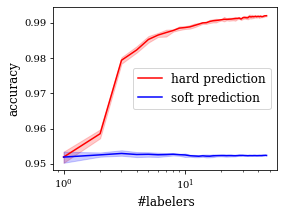

In [8]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(range(1, num_labelers+1), np.mean(acc_hard_prediction, axis=0), color='red', label='hard prediction')
ax.fill_between(range(1, num_labelers+1), 
                np.quantile(acc_hard_prediction, 0.125, axis=0), 
                np.quantile(acc_hard_prediction, 0.875, axis=0), 
                color='red', alpha=.2)
ax.plot(range(1, num_labelers+1), np.mean(acc_soft_prediction, axis=0), color='blue', label='soft prediction')
ax.fill_between(range(1, num_labelers+1), 
                np.quantile(acc_soft_prediction, 0.125, axis=0), 
                np.quantile(acc_soft_prediction, 0.875, axis=0), 
                color='blue', alpha=.2)
ax.set_xlabel('#labelers', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)
ax.set_xscale('log')
ax.legend(fontsize=12)

In [9]:
np.mean(acc_hard_prediction, axis=0)

array([0.95192, 0.95854, 0.97938, 0.9823 , 0.98528, 0.98652, 0.98724,
       0.98782, 0.9885 , 0.98866, 0.98886, 0.98926, 0.98962, 0.98998,
       0.99004, 0.99038, 0.99058, 0.99066, 0.99076, 0.99088, 0.991  ,
       0.99098, 0.99102, 0.99106, 0.99114, 0.9912 , 0.99124, 0.99136,
       0.99106, 0.99144, 0.9915 , 0.99144, 0.99142, 0.9918 , 0.99166,
       0.99176, 0.99172, 0.99184, 0.99172, 0.99186, 0.99174, 0.99186,
       0.99174, 0.9918 , 0.99196, 0.992  , 0.99202])

### accuracy estimation with more samples from p(x)

In [10]:
# sample labels points
num_runs = 50
num_samples = n
acc_soft_prediction = np.zeros((num_runs, num_samples))
acc_hard_prediction = np.zeros((num_runs, num_samples))

s_human_estmated = dataset.s_human[np.arange(num_samples), dataset.y]
for r in range(num_runs):
    idx = np.arange(n)
    np.random.shuffle(idx, )
    for i in range(num_samples):
        acc_soft_prediction[r,i] = s_human_estmated[idx[:i]].mean()
        acc_hard_prediction[r,i] = (dataset.y_human == dataset.y)[idx[:i]].mean()

/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/disij/.conda/envs/bayesian-blackbox/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]


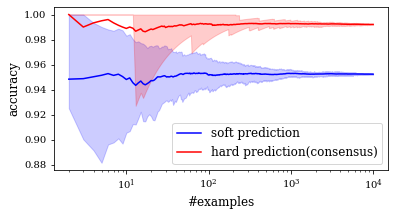

In [11]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(1, num_samples+1), np.mean(acc_soft_prediction, axis=0), color='blue', label='soft prediction')
ax.fill_between(range(1, num_samples+1), 
                np.quantile(acc_soft_prediction, 0.125, axis=0), 
                np.quantile(acc_soft_prediction, 0.875, axis=0), 
                color='blue', alpha=.2)
ax.plot(range(1, num_samples+1), np.mean(acc_hard_prediction, axis=0), color='red', label='hard prediction(consensus)')
ax.fill_between(range(1, num_samples+1), 
                np.quantile(acc_hard_prediction, 0.125, axis=0), 
                np.quantile(acc_hard_prediction, 0.875, axis=0), 
                color='red', alpha=.2)
ax.set_xlabel('#examples', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)
ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize=12)


red curve is above the blue curve because ground truth labels of cifar10 is created with cencensus of multiple labelers, i.e. the red curve always converges to ～100%. 

In [12]:
#####idea

# use model uncertainty to obtain the number of labels
# method 1: randomly select x and get one label for x (without replacement of x)
# method 2: randomly select (x, y) (with replacement of x)
# method 3: more labelers for x that has high model uncertainty
# For each method, a prediction is made by consensus for each x. compare it to ground truth.

sampled_labels_1 = np.zeros((n,k))
sampled_labels_2 = np.zeros((n,k))
sampled_labels_3 = np.zeros((n,k))